# Churn prediction for an energy company 🔌💡
## Part 2 - Data Exploration and Feature Engineering
### Importing packages and data

In [1]:
from utils import *

repo_path = "/workspaces/myfolder/energy-churn-prediction"

client_file_path = f"{repo_path}/data/client_data_cleaned.csv"
client_date_cols = ['date_activ', 'date_modif_prod', 'date_renewal', 'date_end']

price_file_path = f"{repo_path}/data/price_data_cleaned.csv"
price_date_col = 'price_date'

# Load the data and convert datetime columns
client_df = load_and_convert_datetime(client_file_path, client_date_cols)
price_df = load_and_convert_datetime(price_file_path, [price_date_col])

### Imputing missing price values 

Let's start with `price_df`, and let's have a look at the distinct values of `price_date` variable and at the number of unique IDs contained in this table:

In [2]:
print(f"Number of unique IDs: {price_df['id'].nunique()}")
print("\n------------------------------------------------\n")
print("Distinct values of the 'price_date' variable:")
price_df[price_date_col].value_counts().sort_index()

Number of unique IDs: 16096

------------------------------------------------

Distinct values of the 'price_date' variable:


price_date
2015-01-01    16070
2015-02-01    16082
2015-03-01    16074
2015-04-01    16079
2015-05-01    16080
2015-06-01    16085
2015-07-01    16090
2015-08-01    16094
2015-09-01    16082
2015-10-01    16085
2015-11-01    16087
2015-12-01    16094
Name: count, dtype: int64

From the information above, we can infer that this table provides information on price values from January to December 2015 for 16096 customers. However, it seems that there are some missing values here and there for some IDs:

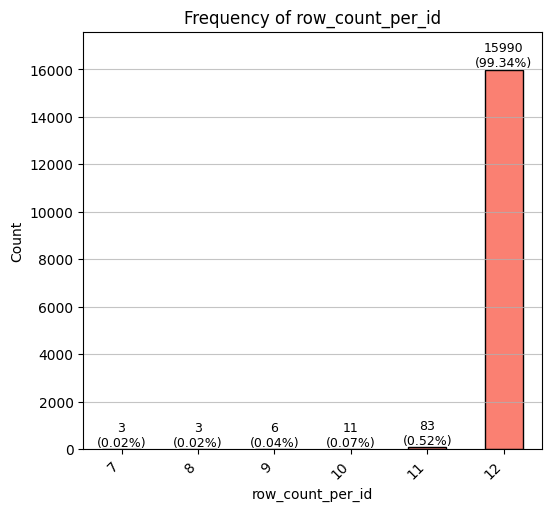

In [3]:
row_counts = price_df.groupby('id').size().reset_index(name='row_count_per_id')

plot_bar_charts(row_counts, ['row_count_per_id'])

It has been decided to impute these missing values with the monthly medians:

In [4]:
price_numeric_cols = price_df.select_dtypes(include=['number']).columns

incomplete_clients = row_counts[row_counts['row_count_per_id'] < 12]["id"]

# Generate a complete date range for each client
date_range = pd.date_range(start="2015-01-01", periods=12, freq='MS')
dates_df = pd.DataFrame({price_date_col: date_range})

# Create complete combinations of client_id and months
all_combinations = (
    incomplete_clients.to_frame()
    .merge(dates_df, how="cross")
    .rename(columns={"id": "client_id"})
)

# Merge with existing data to find missing records
merged_data = (
    all_combinations.merge(
        price_df, left_on=["client_id", price_date_col], right_on=["id", price_date_col], how="left"
    )
    .drop(columns=["id"])
    .rename(columns={"client_id": "id"})
)

# Filter rows where any price variable is missing
missing_rows = merged_data[merged_data[price_numeric_cols].isnull().any(axis=1)]

# Step 5: Compute monthly medians
monthly_medians = price_df.groupby(price_date_col)[price_numeric_cols].median().reset_index()

# Step 6: Impute missing values
missing_rows = missing_rows.merge(monthly_medians, on=price_date_col, suffixes=("", "_Median"))

for col in price_numeric_cols:
    missing_rows[col] = missing_rows[col].fillna(missing_rows[f"{col}_Median"])
    missing_rows.drop(columns=[f"{col}_Median"], inplace=True)

# Concatenate imputed rows with original dataset
price_df = pd.concat([price_df, missing_rows], ignore_index=True)

# Ensure no missing values remain
print("Final Missing Values Check:")
print(price_df.isnull().sum())

Final Missing Values Check:
id                    0
price_date            0
price_off_peak_var    0
price_peak_var        0
price_mid_peak_var    0
price_off_peak_fix    0
price_peak_fix        0
price_mid_peak_fix    0
dtype: int64


### Computing summary statistics for price trends

Let's have a look at the trends for the 6 price variables, by plotting both the average trend and the individual trends for a randomly chosen sample of 100 IDs:

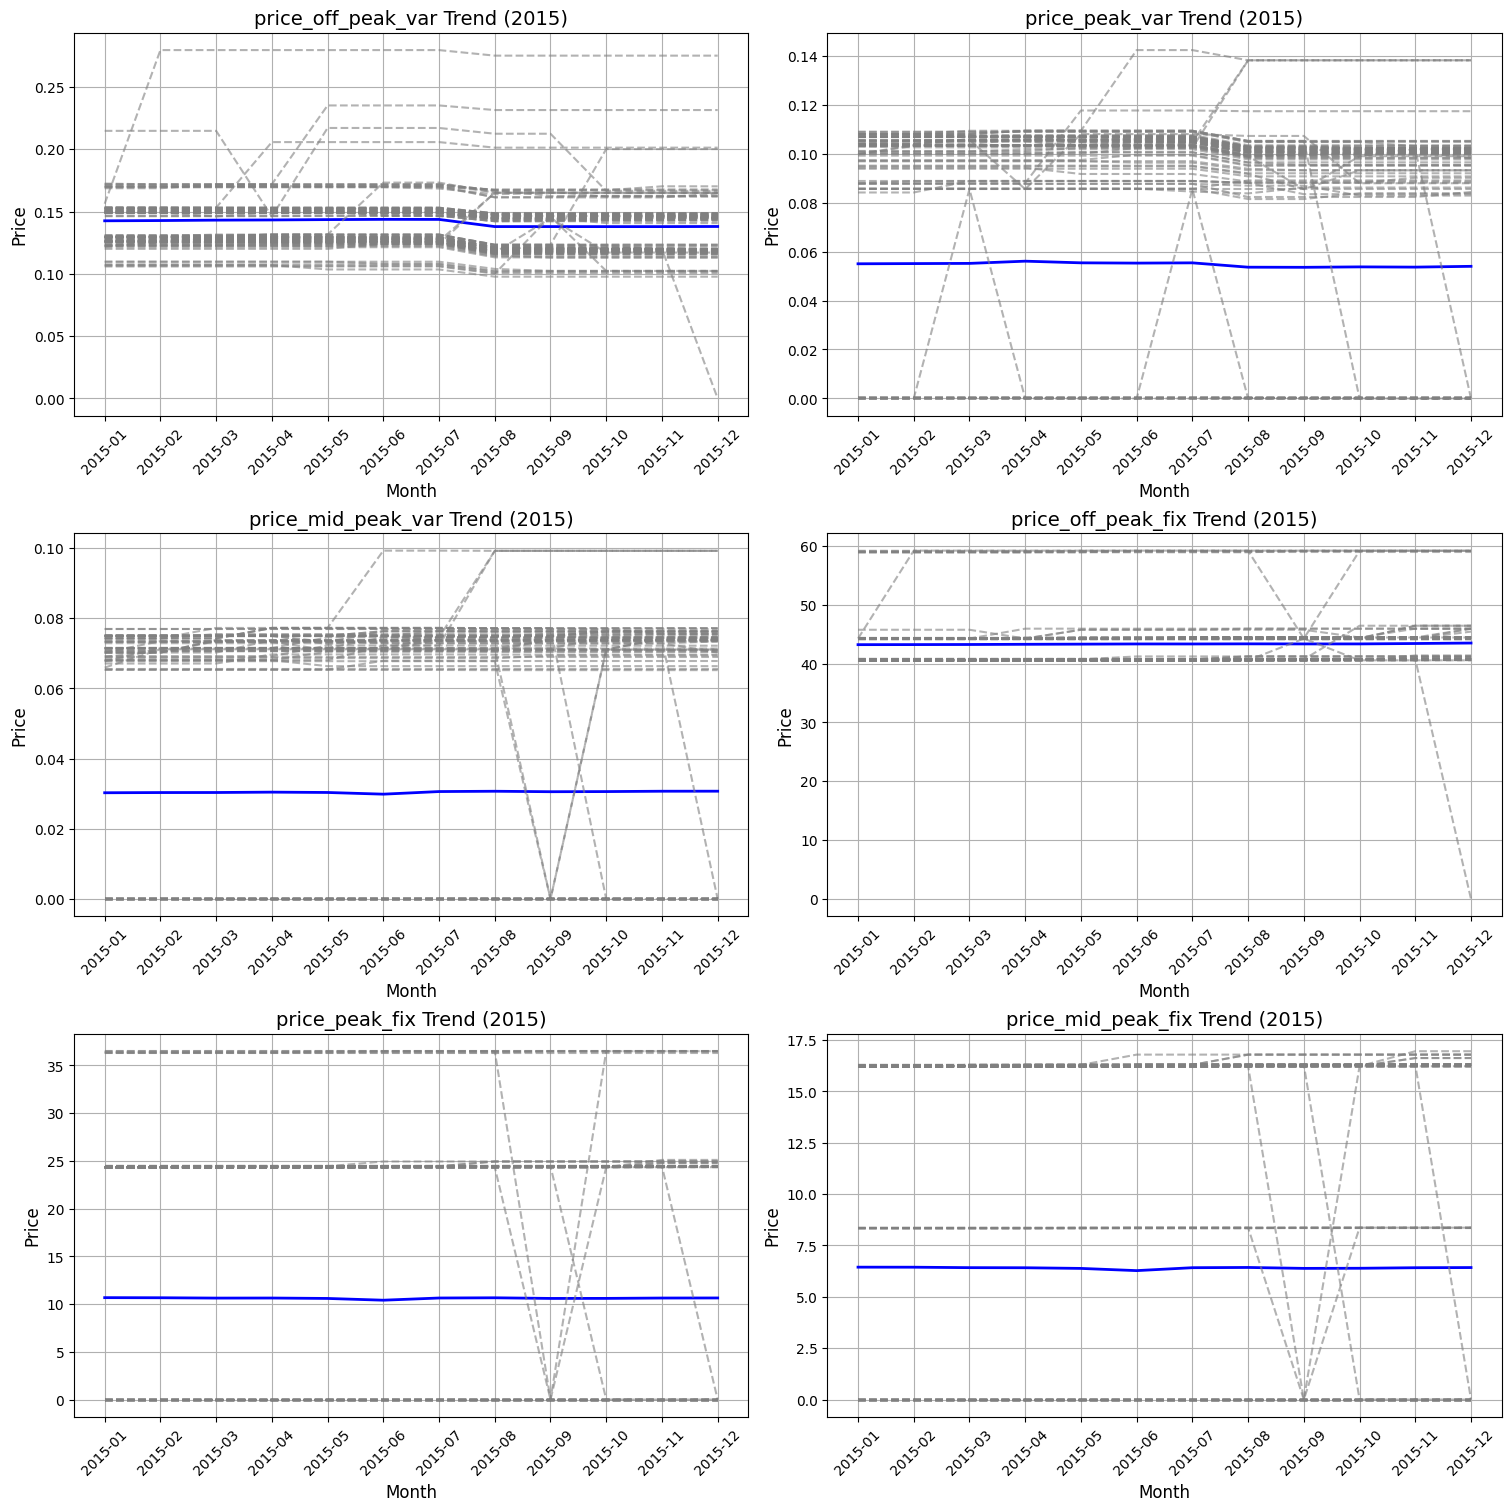

In [5]:
plot_price_trends(price_df, price_numeric_cols, price_date_col, 'id', n_sample=100)

As you can see, while many of the individual trends appear almost constant, some exhibit spikes or troughs. To summarize these trends for joining with the `client_df`, several price features have been engineered, including those capturing these kinds of irregularities, such as the maximum difference between two consecutive months for each customer.

In [6]:
price_df = price_df.sort_values(by=['id', price_date_col])

# Group by 'id'
grouped_df = price_df[['id']+price_numeric_cols.tolist()].groupby('id')

# Compute statistics
mean_df = grouped_df.mean()
median_df = grouped_df.median()
min_df = grouped_df.min()
max_df = grouped_df.max()
std_df = grouped_df.std()
max_diff_df = grouped_df.agg(lambda x: max(x.iloc[i+1] - x.iloc[i] for i in range(len(x)-1)))

# Rename columns for clarity
mean_df.columns = [f"{col}_mean" for col in price_numeric_cols]
median_df.columns = [f"{col}_median" for col in price_numeric_cols]
min_df.columns = [f"{col}_min" for col in price_numeric_cols]
max_df.columns = [f"{col}_max" for col in price_numeric_cols]
std_df.columns = [f"{col}_std" for col in price_numeric_cols]
max_diff_df.columns = [f"{col}_max_diff" for col in price_numeric_cols]

# Join all DataFrames on 'id'
price_summary_df = pd.concat([mean_df, min_df, max_df, std_df, max_diff_df], axis=1)

# Reset index for a cleaner DataFrame if needed
price_summary_df.reset_index(inplace=True)

price_summary_df

,id,price_off_peak_var_mean,price_peak_var_mean,price_mid_peak_var_mean,price_off_peak_fix_mean,price_peak_fix_mean,price_mid_peak_fix_mean,price_off_peak_var_min,price_peak_var_min,price_mid_peak_var_min,...,price_mid_peak_var_std,price_off_peak_fix_std,price_peak_fix_std,price_mid_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_mid_peak_var_max_diff,price_off_peak_fix_max_diff,price_peak_fix_max_diff,price_mid_peak_fix_max_diff
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,0.119906,0.101673,0.070232,...,0.001368,6.341481e-02,0.038049,0.025366,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,0.143943,0.000000,0.000000,...,0.000000,8.753223e-02,0.000000,0.000000,0.000358,0.000000,0.000000,0.177779,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,0.150837,0.000000,0.000000,...,0.000000,7.723930e-01,0.000000,0.000000,0.052694,0.000000,0.000000,1.500000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,0.113068,0.095385,0.068646,...,0.000403,8.507958e-02,0.051048,0.034032,0.000000,0.000000,0.000817,0.162912,0.097752,0.065172
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,0.145440,0.000000,0.000000,...,0.000000,5.908392e-07,0.000000,0.000000,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972,0.112488,0.094804,0.068829,...,0.012503,1.749923e-01,0.209025,0.226040,0.002317,0.002317,0.002317,0.000000,0.000005,0.000002
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000,0.144363,0.000000,0.000000,...,0.000000,8.040373e-02,0.000000,0.000000,0.000684,0.000000,0.000000,0.177780,0.000000,0.000000
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569,0.151399,0.126871,0.091394,...,0.004310,8.491973e-02,0.051364,0.034586,0.004084,0.002317,0.002317,0.164916,0.099749,0.067166
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678,0.118175,0.100491,0.073433,...,0.000471,7.368063e-02,0.044209,0.029474,0.000000,0.000000,0.001083,0.162912,0.097752,0.065172


### Merging the 2 tables

Before analyzing the distribution of these numeric variables, let's perform an inner join `price_summary_df` with `client_df`:

In [7]:
# Perform an inner join based on 'id'
merged_df = pd.merge(client_df, price_summary_df, on='id', how='inner')

merged_df

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price_mid_peak_var_std,price_off_peak_fix_std,price_peak_fix_std,price_mid_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_mid_peak_var_max_diff,price_off_peak_fix_max_diff,price_peak_fix_max_diff,price_mid_peak_fix_max_diff
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.020983,1.050136e+00,7.039226,4.692817,0.028554,0.000568,0.002337,3.538045,0.097752,0.065172
1,d29c2c54acc38ff3c0614d0a653813dd,Channel Missing,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,8.040385e-02,0.000000,0.000000,0.001567,0.085483,0.000000,0.177780,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,8.753223e-02,0.000000,0.000000,0.000000,0.001281,0.000000,0.177779,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,Channel 2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,8.040349e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.177779,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,Channel Missing,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.001588,7.368135e-02,0.044209,0.029473,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14524,18463073fb097fc0ac5d3e040f356987,Channel 1,32270,47940,0,2012-05-24,2016-05-08,2015-05-08,2014-05-26,4648.01,...,0.000000,9.154352e-02,0.000000,0.000000,0.000569,0.000000,0.000000,0.177780,0.000000,0.000000
14525,d0a6f71671571ed83b2645d23af6de00,Channel 1,7223,0,181,2012-08-27,2016-08-27,2012-08-27,2015-08-28,631.69,...,0.000128,1.165389e-01,0.071868,0.016479,0.000000,0.000000,0.000260,0.236688,0.145968,0.033468
14526,10e6828ddd62cbcf687cb74928c4c2d2,Channel 1,1844,0,179,2012-02-08,2016-02-07,2012-02-08,2015-02-09,190.39,...,0.001368,6.341481e-02,0.038049,0.025366,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
14527,1cf20fd6206d7678d5bcafd28c53b4db,Channel 1,131,0,0,2012-08-30,2016-08-30,2012-08-30,2015-08-31,19.34,...,0.000000,8.040379e-02,0.000000,0.000000,0.001567,0.085483,0.000000,0.177780,0.000000,0.000000


### Analysis of date variables

In [8]:
# 2. Create a table with min and max values for each date variable
datetime_cols = merged_df.select_dtypes(include=['datetime']).columns
date_summary = merged_df[datetime_cols].agg(['min', 'max']).transpose()
date_summary.columns = ['Minimum Date', 'Maximum Date']

# Display the results
print("Date Summary Table:")
date_summary

Date Summary Table:


,Minimum Date,Maximum Date
date_activ,2003-05-09,2014-09-01
date_end,2016-01-28,2017-06-13
date_modif_prod,2003-05-09,2016-01-29
date_renewal,2013-06-26,2016-01-28


Before removing the date variables from the dataset, let's create some features out of them:
- `product_modified`: this variable can take value 0 or 1, depending on whether `date_modif_prod` is equal to `date_activ` or not, respectively.
- `contract_age_at_last_modif`: this variable represents the number of days between `date_activ` (contract activation date) and `date_modif_prod` (last product modification date), capturing how long it took for the product to be modified. 
- `days_to_end`: this variable computes the number of days between the end of the historical period (December 31, 2015) and the registered date of the end of the contract.

In [9]:
# Compute 'product_modified'
merged_df.loc[:, 'product_modified'] = (merged_df['date_modif_prod'] > merged_df['date_activ']).astype(int).astype('object')
merged_df.loc[:, 'product_modified'] = merged_df['product_modified'].map({0: 'No', 1: 'Yes'})

# Compute 'contract_age_at_last_modif'
merged_df.loc[:, 'contract_age_at_last_modif'] = (merged_df['date_modif_prod'] - merged_df['date_activ']).dt.days

# Compute 'days_to_end'
historical_end_date = pd.Timestamp('2015-12-31')
merged_df.loc[:, 'days_to_end'] = (merged_df['date_end'] - historical_end_date).dt.days

merged_df[['date_activ', 'date_modif_prod', 'product_modified', 'contract_age_at_last_modif', 'date_end', 'days_to_end']].head(10)

,date_activ,date_modif_prod,product_modified,contract_age_at_last_modif,date_end,days_to_end
0,2013-06-15,2015-11-01,Yes,869,2016-06-15,167
1,2009-08-21,2009-08-21,No,0,2016-08-30,243
2,2010-04-16,2010-04-16,No,0,2016-04-16,107
3,2010-03-30,2010-03-30,No,0,2016-03-30,90
4,2010-01-13,2010-01-13,No,0,2016-03-07,67
5,2011-12-09,2015-11-01,Yes,1423,2016-12-09,344
6,2011-12-02,2011-12-02,No,0,2016-12-02,337
7,2010-04-21,2010-04-21,No,0,2016-04-21,112
8,2011-09-23,2011-09-23,No,0,2016-09-23,267
9,2010-05-04,2015-04-29,Yes,1821,2016-05-04,125


In [10]:
merged_df.drop(datetime_cols, axis=1, inplace=True)

### Saving the first version of the dataset

Before performing additional data transformations and feature engineerings on the numeric and categorical variables, it has been decided to save the current version of the dataset, in order to assess if the subsequent data preparation steps really enhance model performance.

In [11]:
merged_df.to_csv(f"{repo_path}/data/merged_data_no_tfm.csv", index=False)

### Analysis of numeric variables

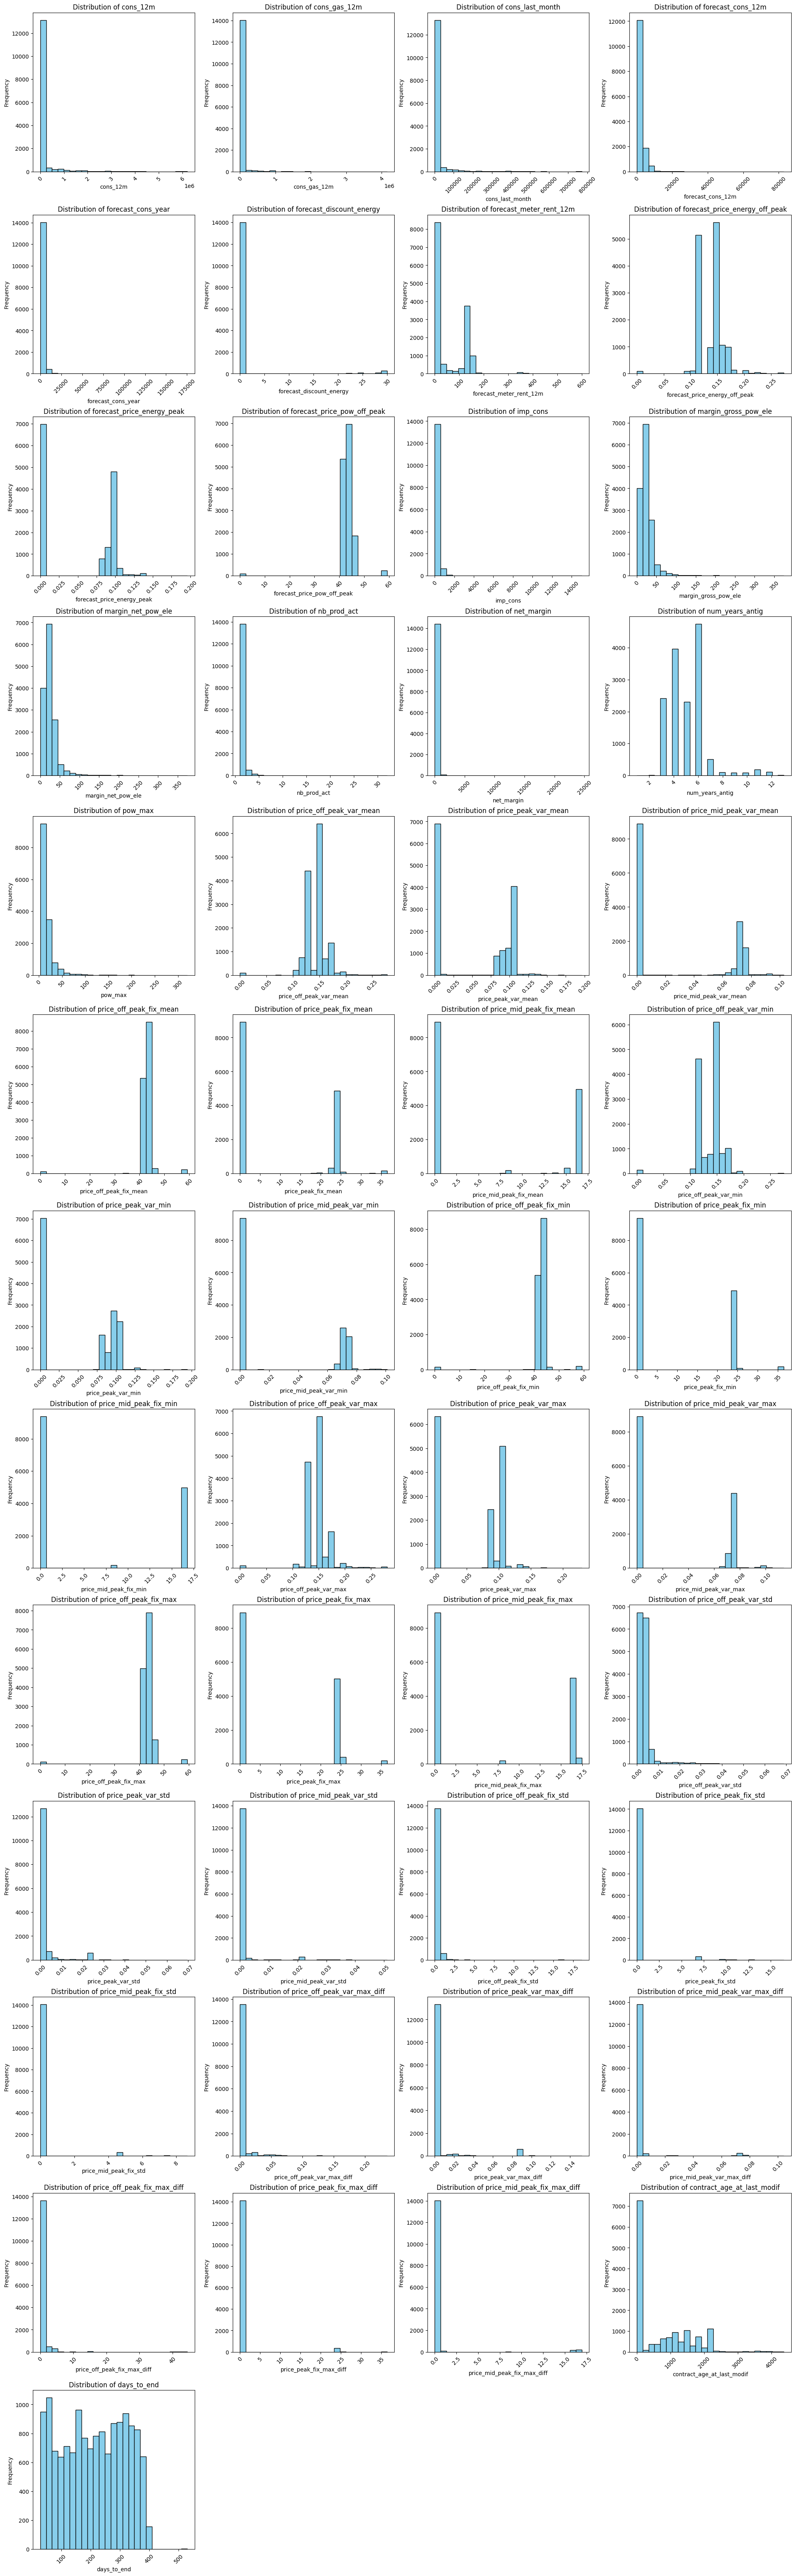

In [12]:
numeric_cols = merged_df.select_dtypes(include='number').columns

plot_numeric_distributions(merged_df, numeric_cols, n_cols=4)

As we can see, there are many extremely skewed predictors. This can be problematic because the number of observations available to predict the target varies greatly across the range of the input values. To have a better understanding of the problem, let's first compute skewness, number of 0s, and cardinality for each of the numeric columns:

In [13]:
num_stats_df = compute_and_sort_statistics(merged_df, numeric_cols, by='cardinality', ascending=True)
num_stats_df

,skewness,zero_counts,cardinality
nb_prod_act,8.665068,0,10
forecast_discount_energy,5.145705,14018,12
num_years_antig,1.448207,0,13
price_mid_peak_fix_min,0.636993,9384,13
price_peak_fix_min,0.658660,9384,13
price_mid_peak_fix_max,0.493465,8909,15
price_peak_fix_max,0.514927,8909,16
price_off_peak_fix_min,-5.748016,139,30
price_peak_fix_max_diff,5.864831,10343,37
price_off_peak_fix_max,-5.263687,105,39


Let's focus on the first 3 variables of the table above (`forecast_discount_energy`, `nb_prod_act` and `num_years_antig`) and plot their value frequencies:

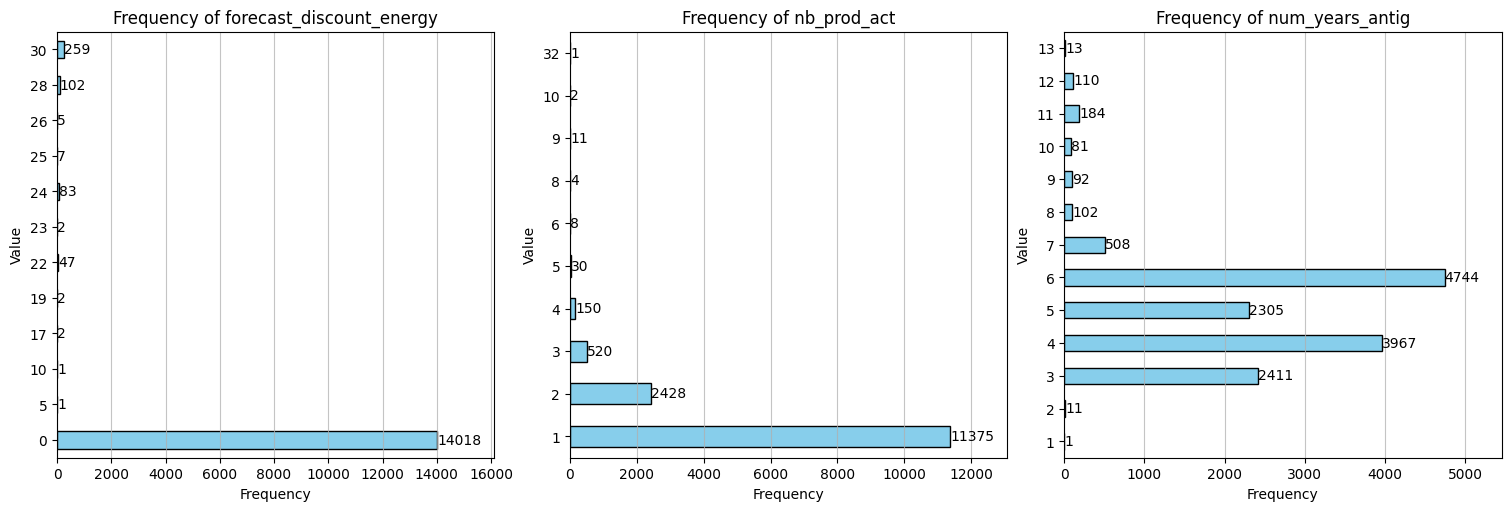

In [14]:
low_cardinality_cols = ['forecast_discount_energy', 'nb_prod_act', 'num_years_antig']

plot_bar_charts(merged_df, low_cardinality_cols, orientation='horizontal', ncols=3)

For these 3 variables, I decided to create the following categorical variables to group rare values and see if this might be helpful in reducing overfit and generalize better on unseen data:
- `nb_prod_act`: 3 categories: '1', '2' and '3 or more'.
- `num_years_antig`: 5 categories: '3 or less', '4', '5', '6' and '7 or more'.
- `forecast_discount_energy`: in this case, since less than 4% of the data has a value different than 0, I decided to just create a flag with values '0' and '>0'.

In [15]:
# Transformation for `nb_prod_act`
merged_df['nb_prod_act_cat'] = np.where(merged_df['nb_prod_act'] >= 3, '3 or more',
                                        merged_df['nb_prod_act'].astype(str))

# Transformation for `num_years_antig`
merged_df['num_years_antig_cat'] = np.where(merged_df['num_years_antig'] <= 3, '3 or less',
                                        np.where(merged_df['num_years_antig'] == 4, '4',
                                                np.where(merged_df['num_years_antig'] == 5, '5',
                                                        np.where(merged_df['num_years_antig'] == 6, '6', '7 or more'))))

# Transformation for `forecast_discount_energy`
merged_df['is_zero_forecast_discount_energy'] = np.where(merged_df['forecast_discount_energy'] > 0, 'No', 'Yes')

# Remove the original variables
merged_df.drop(low_cardinality_cols, axis=1, inplace=True)

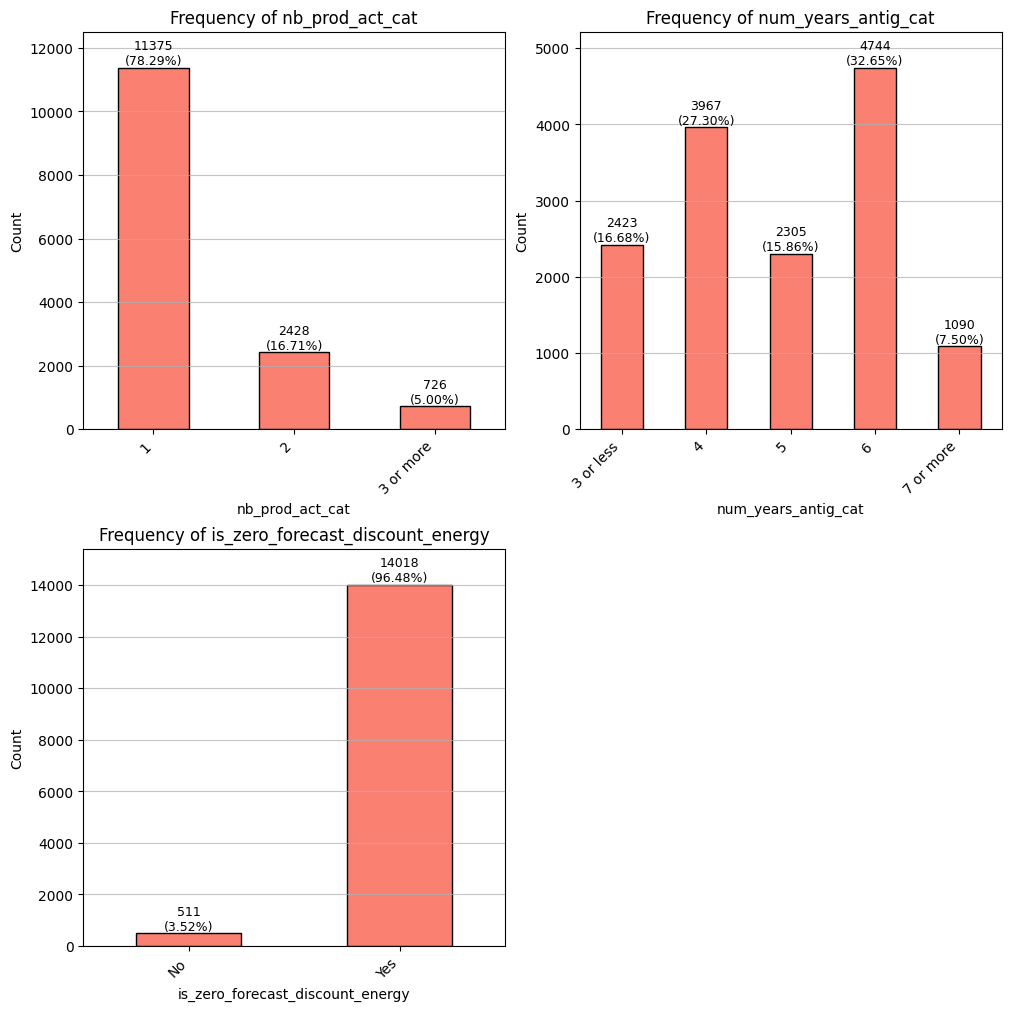

In [16]:
categorized_cols = ['nb_prod_act_cat', 'num_years_antig_cat', 'is_zero_forecast_discount_energy']

plot_bar_charts(merged_df, categorized_cols, orientation='vertical')

In [17]:
numeric_cols = [col for col in numeric_cols if col not in low_cardinality_cols]

num_stats_df = num_stats_df.loc[numeric_cols].sort_values(by='zero_counts', ascending=False)
num_stats_df

,skewness,zero_counts,cardinality
cons_gas_12m,9.640002,11975,2059
price_peak_fix_max_diff,5.864831,10343,37
price_mid_peak_fix_max_diff,5.805980,10307,39
price_mid_peak_fix_std,5.777278,9651,351
price_peak_fix_std,5.749277,9651,364
price_mid_peak_var_max_diff,5.562554,9595,686
price_peak_fix_min,0.658660,9384,13
price_mid_peak_fix_min,0.636993,9384,13
price_mid_peak_var_min,0.618774,9370,332
price_mid_peak_var_std,5.419157,8967,1885


There are several columns with many rows having value 0. Let's see the distributions of the variables with more than 30% of 0 values when removing all these 0 rows:

Skewness for column cons_gas_12m (excluding zeros): 3.912
---------------------------------
Skewness for column cons_last_month (excluding zeros): 5.122
---------------------------------
Skewness for column forecast_cons_year (excluding zeros): 14.926
---------------------------------
Skewness for column forecast_price_energy_peak (excluding zeros): 2.198
---------------------------------
Skewness for column imp_cons (excluding zeros): 11.923
---------------------------------
Skewness for column price_peak_var_mean (excluding zeros): -2.447
---------------------------------
Skewness for column price_mid_peak_var_mean (excluding zeros): -4.023
---------------------------------
Skewness for column price_peak_fix_mean (excluding zeros): -0.139
---------------------------------
Skewness for column price_mid_peak_fix_mean (excluding zeros): -4.341
---------------------------------
Skewness for column price_peak_var_min (excluding zeros): 0.732
---------------------------------
Skewness for 

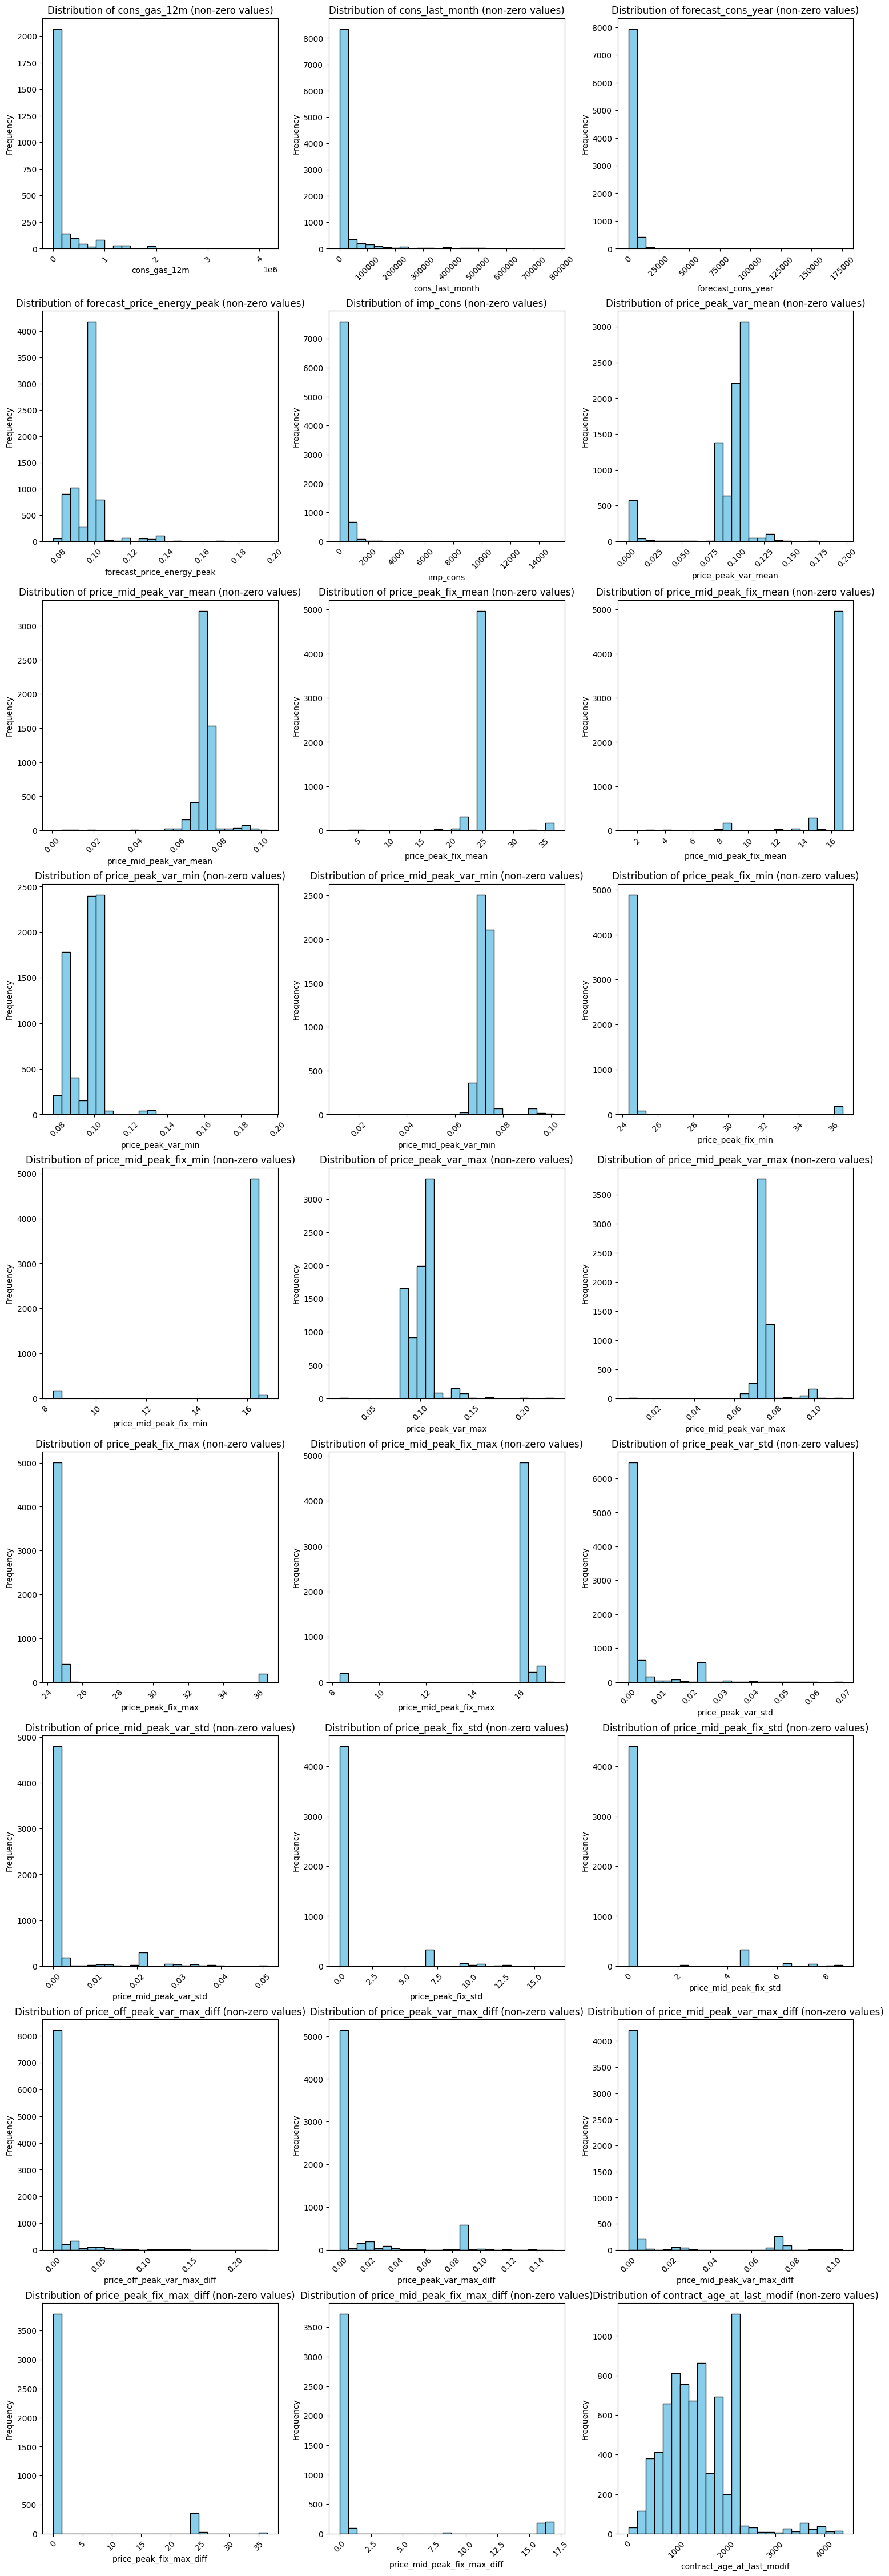

In [18]:
plot_histograms_for_sparse_cols(merged_df, numeric_cols, zero_threshold=0.3)

Some of these distributions remain highly skewed even when removing the 0 values. For all these variables, we can consider to build:
- a flag indicator telling whether the variable is in the spike (0 value) or in the distribution (non-zero value).
- a variable created from the values of the original one in the distribution and where the observations that have the value at the spike are set to missing. A log or square transformation (depending on whether the skewness is greater than 3 or lower than -3, respectively) is then performed on the non-missing values of this variable (except for the variables whose skewness is less than 3 when removing the 0 rows), while missing values will be imputed during the Model Building phase.

In [19]:
many_zeros_cols = [col for col in num_stats_df.index if num_stats_df.loc[col,'zero_counts']>0.3*len(merged_df)]

merged_df, distr_transformed_cols = engineer_saz_features(merged_df, many_zeros_cols, skewness_threshold=3.0)

In [20]:
merged_df.drop(many_zeros_cols, axis=1, inplace=True)

Let's now focus on the remaining numeric variables:

In [21]:
numeric_cols = [col for col in numeric_cols if col not in many_zeros_cols]

num_stats_df = num_stats_df.loc[numeric_cols].sort_values(by='skewness', ascending=False)
num_stats_df

,skewness,zero_counts,cardinality
net_margin,36.540197,184,11917
price_off_peak_fix_max_diff,15.344653,3158,111
price_off_peak_fix_std,14.920628,1386,879
forecast_cons_12m,7.153735,305,13922
price_off_peak_var_std,6.414776,100,4653
cons_12m,5.987711,116,11021
pow_max,5.787936,0,693
margin_net_pow_ele,4.475705,157,2381
margin_gross_pow_ele,4.475003,157,2381
forecast_meter_rent_12m,1.507597,722,3512


For them, I decided to apply a log transformation to all remaining variables with a skewness greater than 3 and a square transformation to all remaining variables with a skewness lower than -3. This was done to achieve a more consistent distribution across their range of values, for the same reasons mentioned earlier.

In [22]:
skewness = num_stats_df['skewness']
cols_to_transform = [col for col in num_stats_df.index if abs(skewness[col])>3]
transformed_cols = []

for col in cols_to_transform:
    if skewness[col]<0:
        col_name = f"{col}_square"
        merged_df[col_name] = merged_df[col].apply(lambda x: x**2)
    elif skewness[col]>0:
        col_name = f"{col}_log"
        merged_df[col_name] = merged_df[col].apply(lambda x: np.log1p(x))

    transformed_cols.append(col_name)

# Print the transformed columns
print(f"Transformed columns: {cols_to_transform}")

Transformed columns: ['net_margin', 'price_off_peak_fix_max_diff', 'price_off_peak_fix_std', 'forecast_cons_12m', 'price_off_peak_var_std', 'cons_12m', 'pow_max', 'margin_net_pow_ele', 'margin_gross_pow_ele', 'forecast_price_pow_off_peak', 'price_off_peak_fix_max', 'price_off_peak_fix_mean', 'price_off_peak_fix_min']


In [23]:
merged_df.drop(cols_to_transform, axis=1, inplace=True)

Let's now conclude the data preparation phase by examining the categorical variables.

### Categorical variables

In [24]:
categorical_cols = [col for col in merged_df.select_dtypes(exclude='number').columns if col!='id']
categorical_cols

['channel_sales',
 'has_gas',
 'origin_up',
 'churn',
 'product_modified',
 'nb_prod_act_cat',
 'num_years_antig_cat',
 'is_zero_forecast_discount_energy',
 'is_zero_cons_gas_12m',
 'is_zero_price_peak_fix_max_diff',
 'is_zero_price_mid_peak_fix_max_diff',
 'is_zero_price_mid_peak_fix_std',
 'is_zero_price_peak_fix_std',
 'is_zero_price_mid_peak_var_max_diff',
 'is_zero_price_peak_fix_min',
 'is_zero_price_mid_peak_fix_min',
 'is_zero_price_mid_peak_var_min',
 'is_zero_price_mid_peak_var_std',
 'is_zero_price_mid_peak_fix_mean',
 'is_zero_price_peak_fix_max',
 'is_zero_price_mid_peak_fix_max',
 'is_zero_price_peak_fix_mean',
 'is_zero_price_mid_peak_var_mean',
 'is_zero_price_mid_peak_var_max',
 'is_zero_price_peak_var_max_diff',
 'is_zero_contract_age_at_last_modif',
 'is_zero_price_peak_var_min',
 'is_zero_forecast_price_energy_peak',
 'is_zero_price_peak_var_std',
 'is_zero_price_peak_var_max',
 'is_zero_price_peak_var_mean',
 'is_zero_imp_cons',
 'is_zero_forecast_cons_year',
 'is_

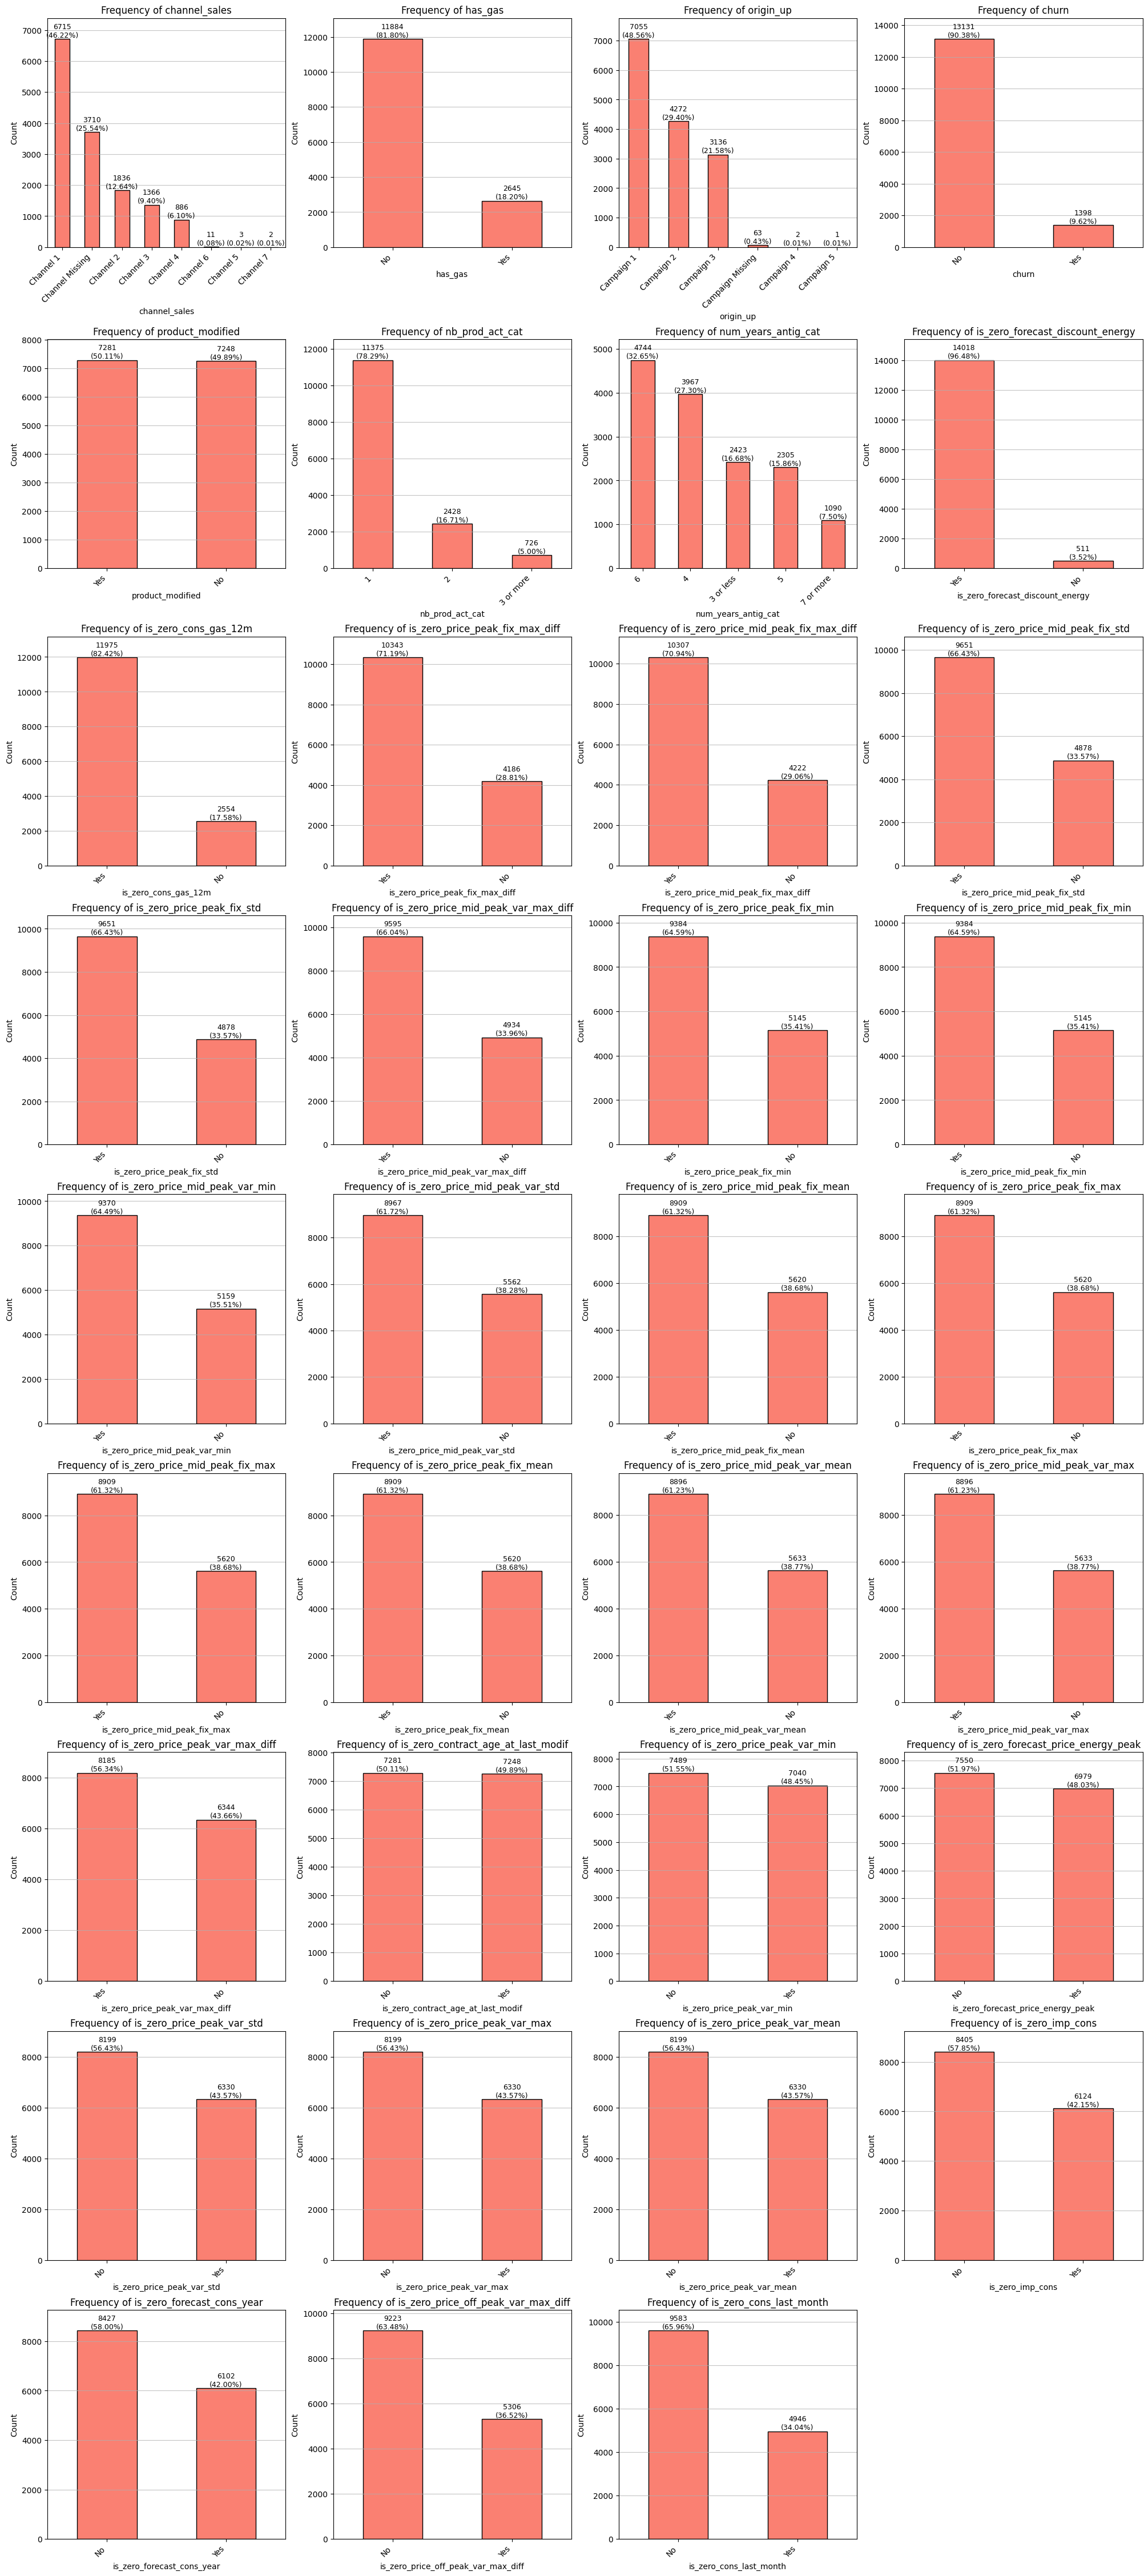

In [25]:
plot_bar_charts(merged_df, categorical_cols, sort_index=False, ncols=4)

As you can see, some categories are very poorly represented:

- `'Channel 5'`, `'Channel 6'` and `'Channel 7'` for the `channel_sales` variable
- `'Campaign 4'`, `'Campaign 5'` and `'Campaign Missing'` for the `origin_up` variable

Since these categories are underrepresented, they are likely to introduce noise into the data without providing sufficient examples to learn meaningful patterns. Therefore, I decided to remove the rows corresponding to categories that account for less than 1% of the total observations.

In [26]:
merged_df = remove_underrepresented_categories(merged_df, categorical_cols)


Removed categories from 'channel_sales':
  - Channel 6
  - Channel 5
  - Channel 7

Removed categories from 'origin_up':
  - Campaign Missing
  - Campaign 4
  - Campaign 5


### Removing highly correlated variables

Let's plot the **correlation matrix** for the numeric variables, displaying only cells with a correlation greater than 0.9:

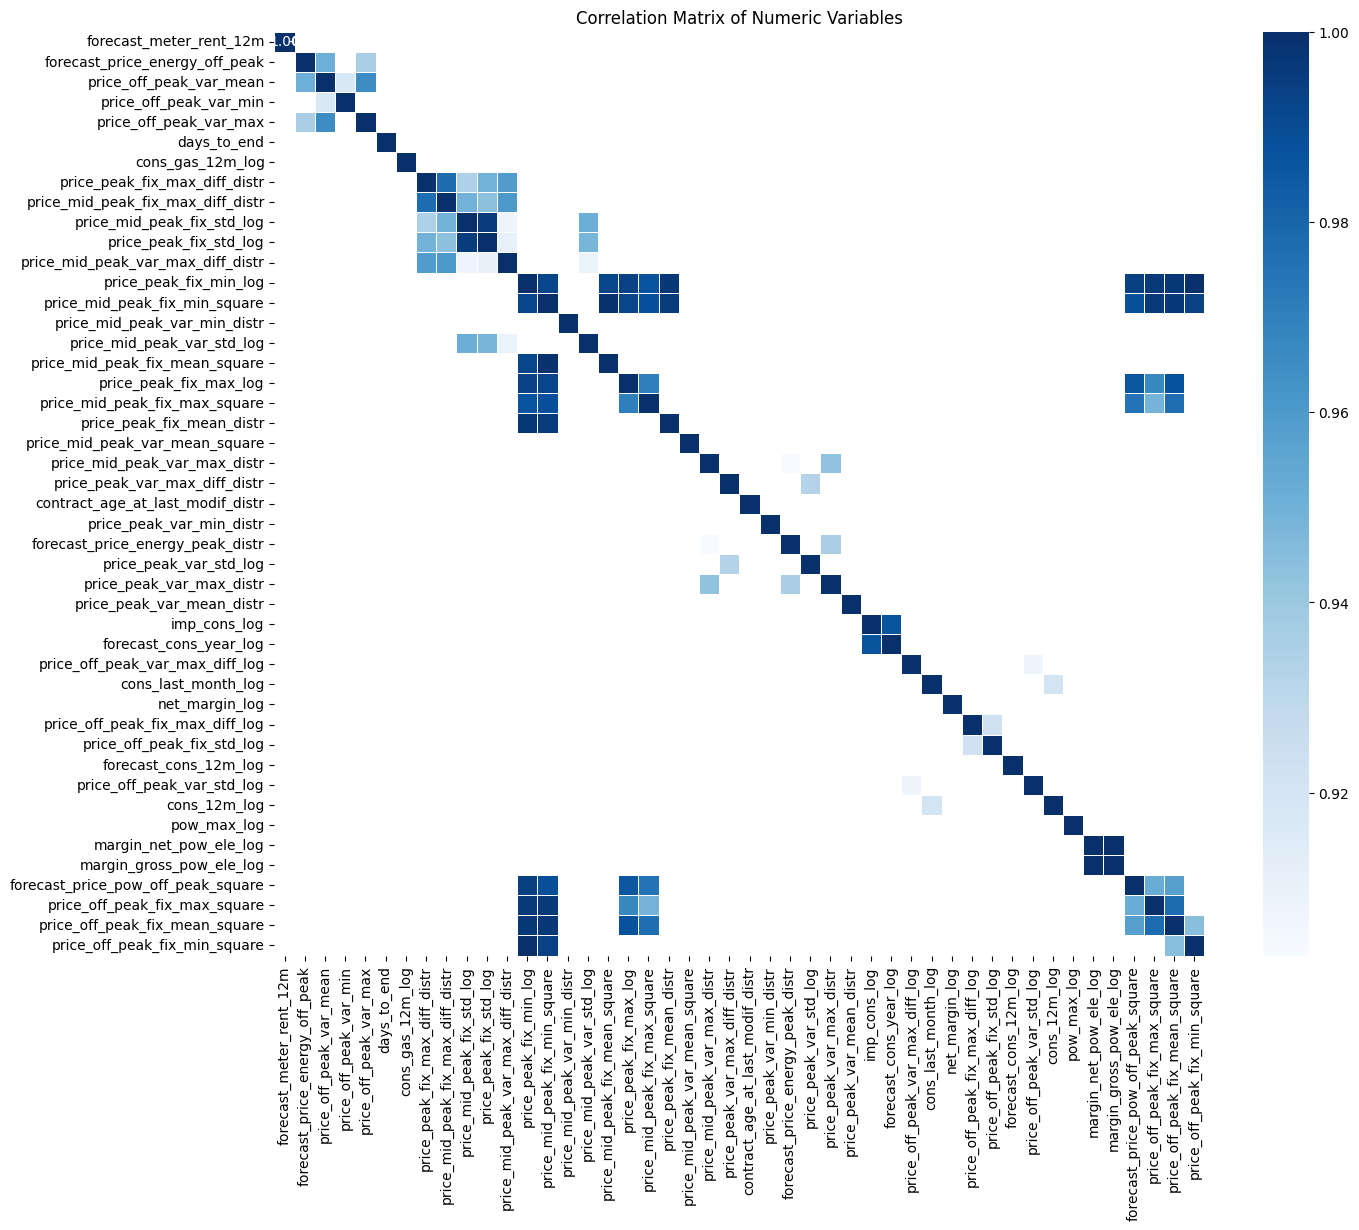

,variable_1,variable_2,correlation
1020,margin_net_pow_ele_log,margin_gross_pow_ele_log,0.999892
506,price_peak_fix_min_log,price_off_peak_fix_min_square,0.999798
509,price_mid_peak_fix_min_square,price_mid_peak_fix_mean_square,0.999109
505,price_peak_fix_min_log,price_off_peak_fix_mean_square,0.997273
480,price_peak_fix_min_log,price_peak_fix_mean_distr,0.997244
504,price_peak_fix_min_log,price_off_peak_fix_max_square,0.995960
369,price_mid_peak_fix_std_log,price_peak_fix_std_log,0.995247
503,price_peak_fix_min_log,forecast_price_pow_off_peak_square,0.993943
478,price_peak_fix_min_log,price_peak_fix_max_log,0.993608
511,price_mid_peak_fix_min_square,price_mid_peak_fix_max_square,0.988185


In [27]:
high_corr_pairs = plot_correlation_matrix(merged_df, merged_df.select_dtypes(include='number').columns)
high_corr_pairs.sort_values(by="correlation", ascending=False)

As you can see, several pairs of variables exhibit a high correlation (greater than 0.9), meaning they convey nearly the same information. To reduce redundancy, we applied the custom `process_graph` function, which iteratively removes variables based on their connectivity in the correlation graph. Specifically, within each connected component of highly correlated variables, the function removes nodes (variables) with the highest number of connections, prioritizing those with the strongest correlations. The process continues until no strongly correlated pairs remain, ensuring that only the most representative variables are retained.

In [28]:
variables_to_remove = process_graph(high_corr_pairs)

Initial graph:
Graph with 35 nodes and 54 edges
The graph is made of the following components:
1) {'forecast_price_energy_off_peak', 'price_off_peak_var_mean', 'price_off_peak_var_min', 'price_off_peak_var_max'}
2) {'price_peak_fix_max_diff_distr', 'price_mid_peak_fix_max_diff_distr', 'price_mid_peak_var_std_log', 'price_mid_peak_var_max_diff_distr', 'price_mid_peak_fix_std_log', 'price_peak_fix_std_log'}
3) {'price_mid_peak_fix_max_square', 'price_off_peak_fix_max_square', 'price_off_peak_fix_min_square', 'price_peak_fix_max_log', 'forecast_price_pow_off_peak_square', 'price_mid_peak_fix_min_square', 'price_mid_peak_fix_mean_square', 'price_peak_fix_mean_distr', 'price_off_peak_fix_mean_square', 'price_peak_fix_min_log'}
4) {'price_peak_var_max_distr', 'forecast_price_energy_peak_distr', 'price_mid_peak_var_max_distr'}
5) {'price_peak_var_std_log', 'price_peak_var_max_diff_distr'}
6) {'forecast_cons_year_log', 'imp_cons_log'}
7) {'price_off_peak_var_std_log', 'price_off_peak_var_max_d

In [29]:
print("Variables to remove:", variables_to_remove)
print("Pre-removal shape:", merged_df.shape)
merged_df.drop(variables_to_remove, axis=1, inplace=True)
print("Post-removal shape:", merged_df.shape)

merged_df.to_csv(f"{repo_path}/data/merged_data_tfm.csv", index=False)

Variables to remove: ['price_off_peak_var_mean', 'price_mid_peak_fix_std_log', 'price_peak_fix_min_log', 'price_peak_var_max_distr', 'price_peak_var_max_diff_distr', 'forecast_cons_year_log', 'price_off_peak_var_max_diff_log', 'cons_12m_log', 'price_off_peak_fix_max_diff_log', 'margin_gross_pow_ele_log', 'forecast_price_energy_off_peak', 'price_mid_peak_var_max_diff_distr', 'price_mid_peak_fix_min_square', 'forecast_price_energy_peak_distr', 'price_peak_fix_std_log', 'price_off_peak_fix_mean_square', 'price_mid_peak_fix_max_diff_distr', 'price_peak_fix_max_log', 'price_off_peak_fix_max_square', 'forecast_price_pow_off_peak_square']
Pre-removal shape: (14447, 82)
Post-removal shape: (14447, 62)


Finally, let's apply the same process to the table previously saved in the `merged_data_no_tfm.csv` file and update its content accordingly:

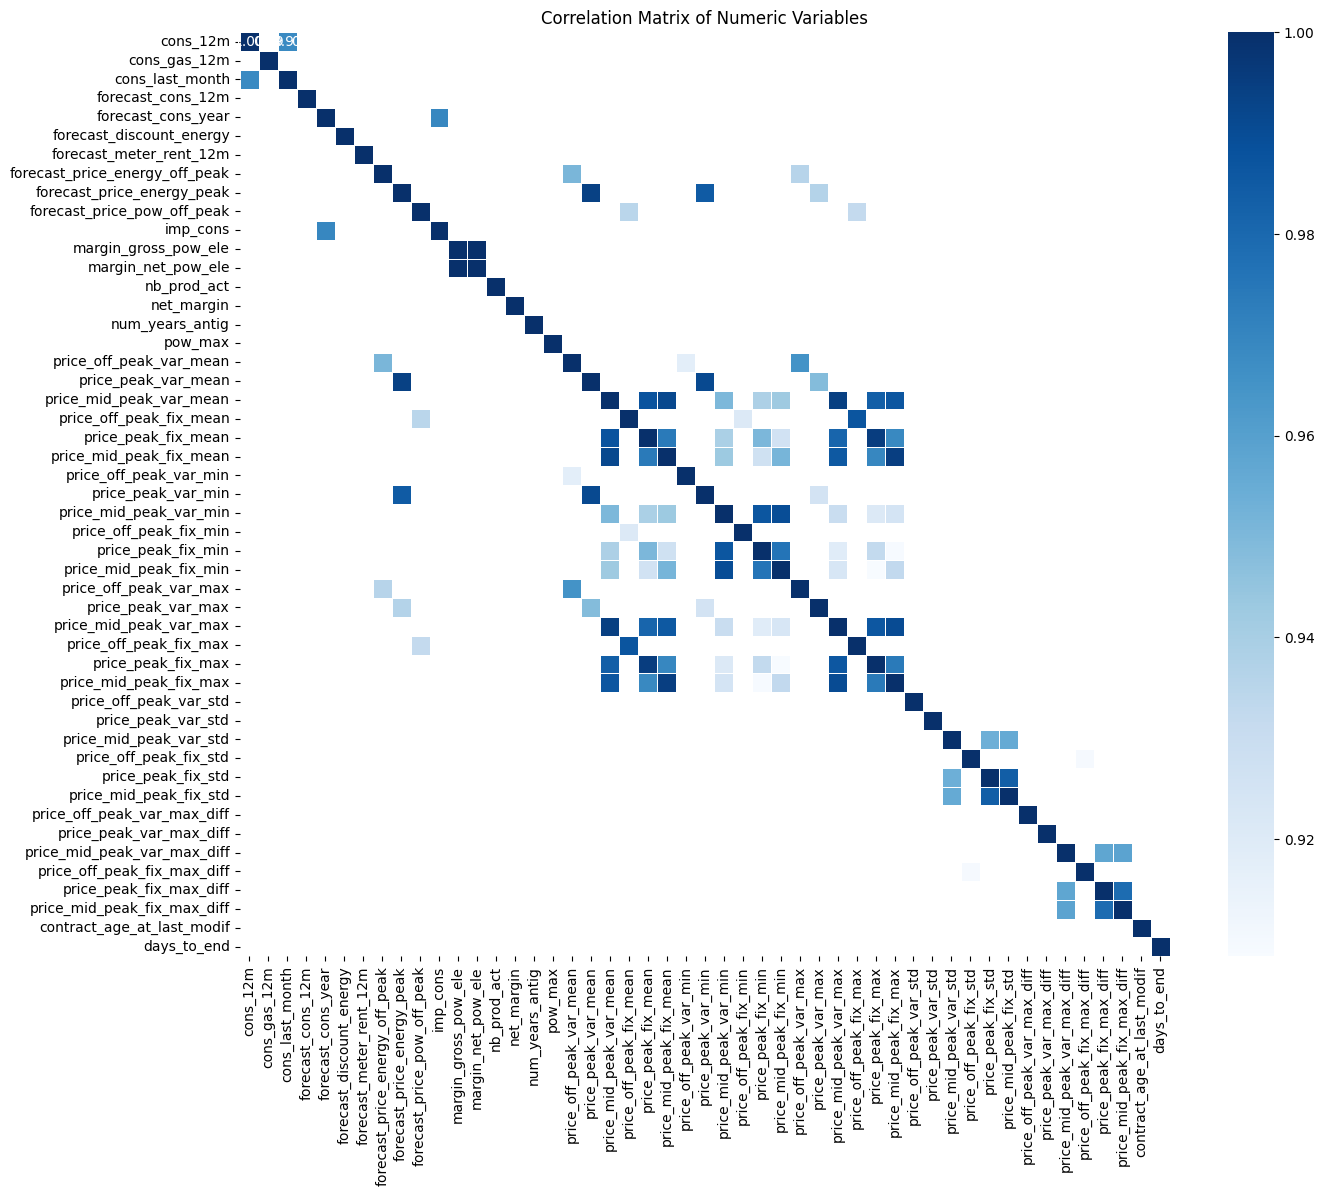

,variable_1,variable_2,correlation
473,margin_gross_pow_ele,margin_net_pow_ele,0.999913
809,price_peak_fix_mean,price_peak_fix_max,0.995177
836,price_mid_peak_fix_mean,price_mid_peak_fix_max,0.994846
752,price_mid_peak_var_mean,price_mid_peak_var_max,0.994414
365,forecast_price_energy_peak,price_peak_var_mean,0.993929
743,price_mid_peak_var_mean,price_mid_peak_fix_mean,0.991498
716,price_peak_var_mean,price_peak_var_min,0.991102
1025,price_mid_peak_var_max,price_mid_peak_fix_max,0.990589
902,price_mid_peak_var_min,price_mid_peak_fix_min,0.989910
742,price_mid_peak_var_mean,price_peak_fix_mean,0.987631


In [30]:
merged_no_tfm_df = pd.read_csv(f"{repo_path}/data/merged_data_no_tfm.csv")

high_corr_pairs = plot_correlation_matrix(merged_no_tfm_df, merged_no_tfm_df.select_dtypes(include='number').columns)
high_corr_pairs.sort_values(by="correlation", ascending=False)

In [31]:
variables_to_remove = process_graph(high_corr_pairs)

Initial graph:
Graph with 35 nodes and 60 edges
The graph is made of the following components:
1) {'cons_last_month', 'cons_12m'}
2) {'imp_cons', 'forecast_cons_year'}
3) {'forecast_price_energy_off_peak', 'price_off_peak_var_mean', 'price_off_peak_var_min', 'price_off_peak_var_max'}
4) {'price_peak_var_max', 'forecast_price_energy_peak', 'price_peak_var_min', 'price_peak_var_mean'}
5) {'price_off_peak_fix_max', 'price_off_peak_fix_mean', 'forecast_price_pow_off_peak', 'price_off_peak_fix_min'}
6) {'margin_gross_pow_ele', 'margin_net_pow_ele'}
7) {'price_mid_peak_var_mean', 'price_peak_fix_max', 'price_peak_fix_min', 'price_mid_peak_fix_max', 'price_mid_peak_fix_min', 'price_mid_peak_fix_mean', 'price_mid_peak_var_min', 'price_peak_fix_mean', 'price_mid_peak_var_max'}
8) {'price_mid_peak_var_std', 'price_mid_peak_fix_std', 'price_peak_fix_std'}
9) {'price_off_peak_fix_std', 'price_off_peak_fix_max_diff'}
10) {'price_mid_peak_fix_max_diff', 'price_peak_fix_max_diff', 'price_mid_peak_var

In [32]:
print("Variables to remove:", variables_to_remove)
print("Pre-removal shape:", merged_no_tfm_df.shape)
merged_no_tfm_df.drop(variables_to_remove, axis=1, inplace=True)
print("Post-removal shape:", merged_no_tfm_df.shape)

merged_no_tfm_df.to_csv(f"{repo_path}/data/merged_data_no_tfm.csv", index=False)

Variables to remove: ['cons_12m', 'forecast_cons_year', 'price_off_peak_var_mean', 'price_peak_var_mean', 'price_off_peak_fix_mean', 'margin_gross_pow_ele', 'price_peak_fix_mean', 'price_mid_peak_fix_std', 'price_off_peak_fix_max_diff', 'price_mid_peak_fix_max_diff', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'price_mid_peak_fix_mean', 'price_mid_peak_var_std', 'price_mid_peak_var_max_diff', 'price_peak_var_max', 'price_mid_peak_var_max', 'price_mid_peak_var_min', 'price_mid_peak_var_mean', 'price_mid_peak_fix_min', 'price_peak_fix_max', 'price_mid_peak_fix_max']
Pre-removal shape: (14529, 55)
Post-removal shape: (14529, 32)
